Train label counts: Counter({10: 105, 11: 58, 5: 35, 4: 34, 9: 33, 12: 31, 1: 30, 0: 26, 7: 22, 3: 14, 6: 10, 2: 8, 8: 6})
Val   label counts: Counter({10: 27, 11: 14, 5: 9, 4: 8, 12: 8, 9: 8, 1: 8, 0: 7, 7: 6, 3: 3, 8: 2, 2: 2, 6: 2})
Epoch 01 | Train Loss: 2.4447, Acc: 0.2403 | Val   Loss: 2.2752, Acc: 0.5000
Epoch 02 | Train Loss: 1.8956, Acc: 0.6796 | Val   Loss: 1.6152, Acc: 0.7019
Epoch 03 | Train Loss: 1.4034, Acc: 0.8252 | Val   Loss: 1.1972, Acc: 0.7692
Epoch 04 | Train Loss: 1.0633, Acc: 0.8617 | Val   Loss: 0.9323, Acc: 0.8077
Epoch 05 | Train Loss: 0.8138, Acc: 0.8932 | Val   Loss: 0.7341, Acc: 0.8173
Epoch 06 | Train Loss: 0.6328, Acc: 0.9126 | Val   Loss: 0.5832, Acc: 0.8462
Epoch 07 | Train Loss: 0.4680, Acc: 0.9466 | Val   Loss: 0.4932, Acc: 0.8846
Epoch 08 | Train Loss: 0.3647, Acc: 0.9490 | Val   Loss: 0.4345, Acc: 0.9231
Epoch 09 | Train Loss: 0.2674, Acc: 0.9684 | Val   Loss: 0.3810, Acc: 0.9135
Epoch 10 | Train Loss: 0.2488, Acc: 0.9636 | Val   Loss: 0.3523, Acc: 0

/Users/berrecelik/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/berrecelik/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/berrecelik/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

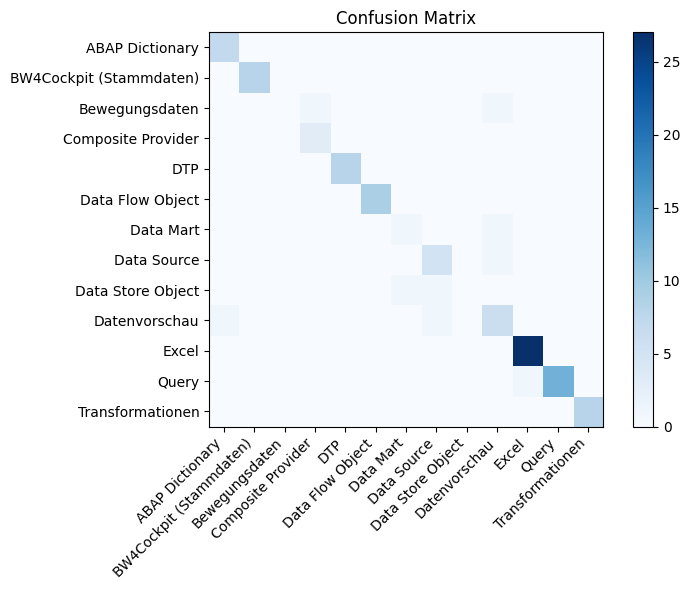

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

# ————————————————————————————————
# 0) Device detection
# ————————————————————————————————
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda  = (device.type == "cuda")

# ————————————————————————————————
# 1) Paths & hyperparameters
# ————————————————————————————————
data_dir   = "/Users/berrecelik/Desktop/dataset/train"  # tek klasörde label alt klasörleri
val_frac   = 0.2
batch_size = 32
num_epochs = 13
lr         = 1e-4

# ————————————————————————————————
# 2) Data transforms
# ————————————————————————————————
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ————————————————————————————————
# 3) Load full dataset (with train_transform)
# ————————————————————————————————
full_ds = datasets.ImageFolder(data_dir, transform=train_transform)
classes = full_ds.classes
y       = full_ds.targets  # her örneğin label indeksi

# ————————————————————————————————
# 4) Stratified split indices
# ————————————————————————————————
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_frac, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))

# (opsiyonel) dağılımı gözlemle
print("Train label counts:", Counter([y[i] for i in train_idx]))
print("Val   label counts:", Counter([y[i] for i in val_idx]))

# ————————————————————————————————
# 5) Create Subsets and set transforms
# ————————————————————————————————
train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
# val için diğer transform’u ata
val_ds.dataset.transform = val_transform

# ————————————————————————————————
# 6) DataLoaders
# ————————————————————————————————
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=use_cuda
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=use_cuda
)

# ————————————————————————————————
# 7) Model setup
# ————————————————————————————————
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ————————————————————————————————
# 8) Training loop
# ————————————————————————————————
best_val_acc = 0.0
best_state  = None

for epoch in range(1, num_epochs+1):
    # — train —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1)==labels).sum().item()
        train_total += imgs.size(0)
    train_loss /= train_total
    train_acc  = train_correct / train_total

    # — validate —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds==labels).sum().item()
            val_total += imgs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= val_total
    val_acc  = val_correct / val_total

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state  = model.state_dict()

# en iyi ağırlıkları kaydet ve yükle
torch.save(best_state, "best_model.pth")
print(f"Best Val Accuracy: {best_val_acc:.4f}")

# ————————————————————————————————
# 9) Final report
# ————————————————————————————————
model.load_state_dict(best_state)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
xticks = np.arange(len(classes))
plt.xticks(xticks, classes, rotation=45, ha="right")
plt.yticks(xticks, classes)
plt.tight_layout()
plt.show()
